# Quality control on the beetle risk pipeline

This notebook performs some quality control on the data products produced in the beetle risk data pipeline.

Run this cell below before running any other cell in the notebook:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
import xarray as xr
from rasterio.plot import show
# project imports
from config import *
# import the compute yearly risk script to
#  borrow functions for sanity checking
import compute_yearly_risk as yearly_risk
# same for classify_clip_mask script
import classify_clip_mask as ccm

## Metadata and tag checks

Define a function to read the metadata from a GeoTIFF and read it from all of the new GeoTIFFs in the risk classes dataset:

In [2]:
def get_meta(fp):
    with rio.open(fp) as src:
        profile = src.profile
        tags = src.tags()
    
    return (profile, tags)

all_meta = [get_meta(fp) for fp in out_risk_dir.glob("*.tif")]

Assert that all metadata and tags are the same for all files in the dataset:

In [3]:
assert(all(x == all_meta[0] for x in all_meta))

## Data values sanity check

Check that data values are as expected.



In [4]:
stat_di = {}
for fp in out_risk_dir.glob("*.tif"):
    key = fp.name
    stat_di[key] = {}
    with rio.open(fp) as src:
        stat_di[key]["counts"] = np.unique(src.read(1), return_counts=True)

Possible values for this dataset are 0, 1, 2, and 3, and the distribution should skew towards 1, and 0 should show up in the same abundance for each slice.

In [5]:
low, med, high = [], [], []
for fn in stat_di:
    assert set(stat_di[fn]["counts"][0]).issubset(np.array([0, 1, 2, 3]))
    assert stat_di[fn]["counts"][1][0] == stat_di[list(stat_di.keys())[0]]["counts"][1][0]
    low.append(stat_di[fn]["counts"][1][1])
    med.append(stat_di[fn]["counts"][1][2])
    # there might not be "high" risk..
    try:
        high.append(stat_di[fn]["counts"][1][3])
    except IndexError:
        high.append(0)

Plot some histograms of the pixel counts for each risk category across all files:

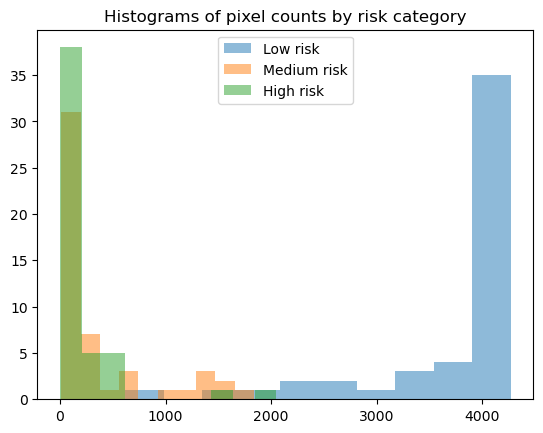

In [6]:
plt.hist(low, 
         alpha=0.5, # the transaparency parameter
         label="Low risk")
  
plt.hist(med,
         alpha=0.5,
         label="Medium risk")

plt.hist(high,
         alpha=0.5,
         label="High risk")
  
plt.legend(loc="upper center")
plt.title("Histograms of pixel counts by risk category")
plt.show()

The histograms look about as expected - vast majority of pixels are low risk in most files, with far fewer medium risk pixels and even fewer high risk pixels.

## Maps

We can go ahead plot some of these data files as maps:

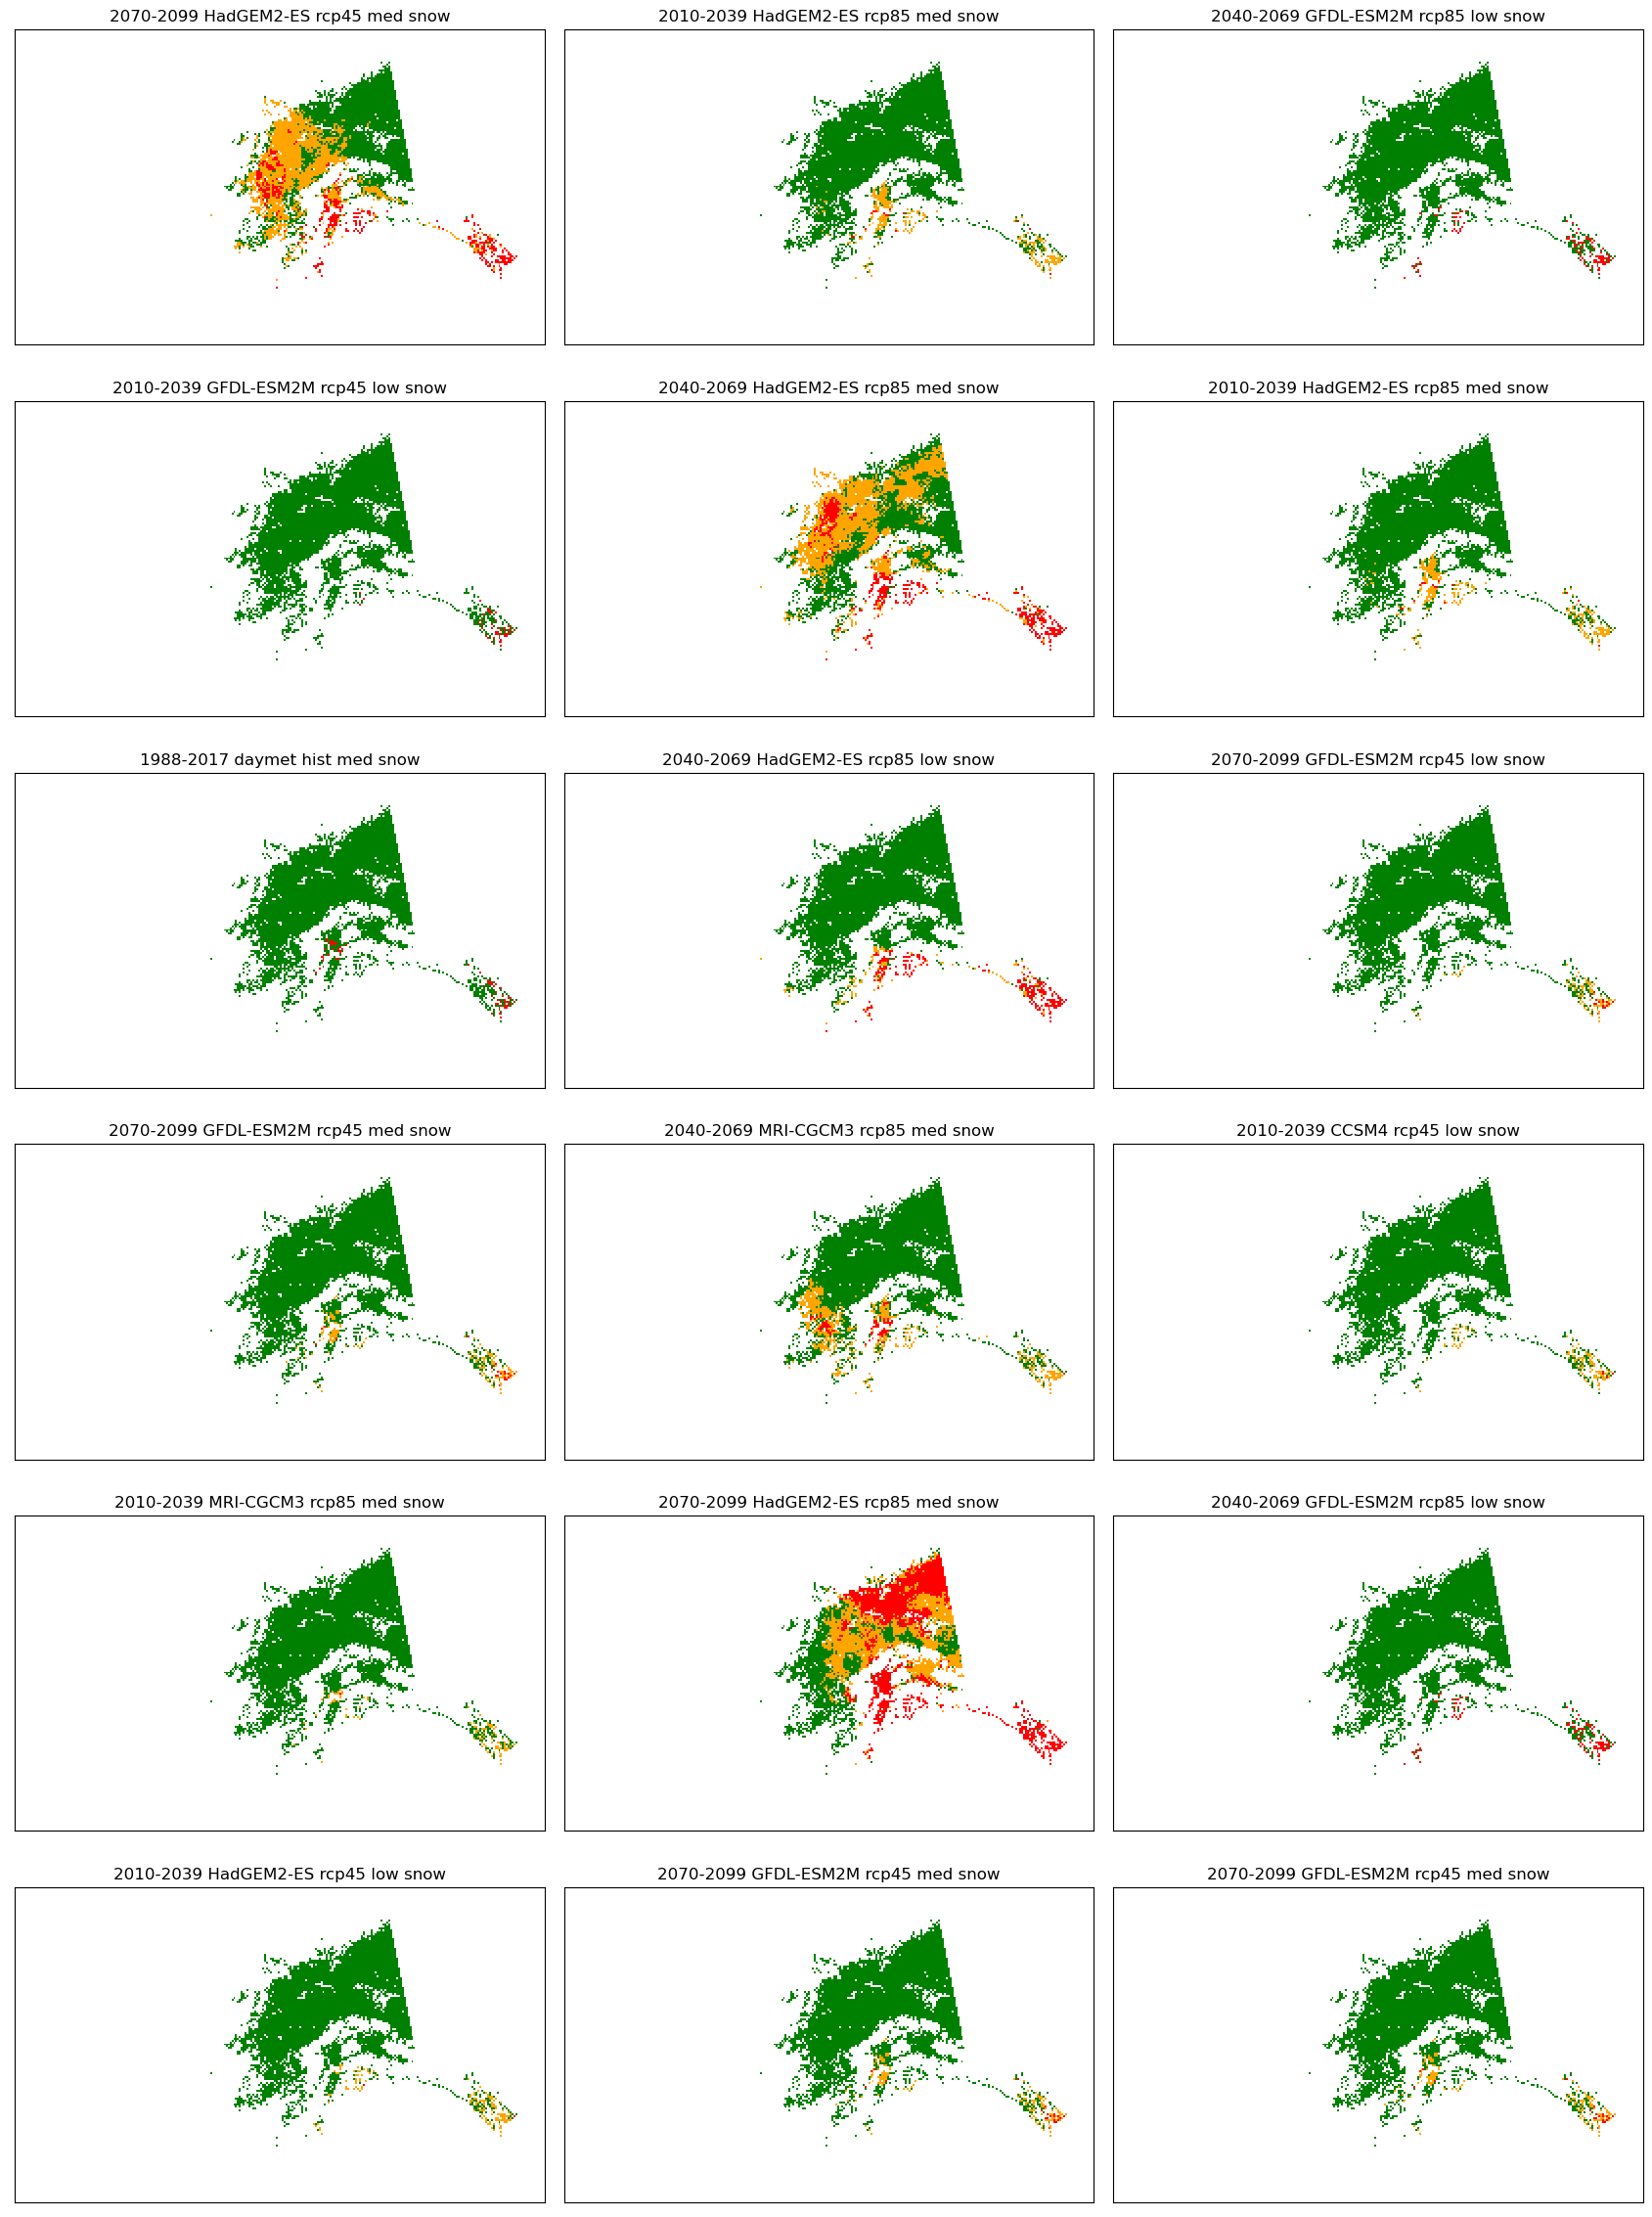

In [7]:
from matplotlib.colors import ListedColormap


# choose 18 random files
np.random.seed(907)
idx = np.random.randint(0, 50, 18)
all_fps = list(out_risk_dir.glob("*.tif"))
fps = [all_fps[i] for i in idx]
cmap = ListedColormap(["green", "orange", "red"])

fig, axs = plt.subplots(6, 3, figsize=(17, 23), sharex=True, sharey=True)
fig.patch.set_facecolor("white")
for ax, fp in zip(axs.flatten(), fps):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    era, model, scenario, snow = fp.name.split("_")[-4:]
    snow = snow.replace(".tif", "")
    with rio.open(fp) as src:
        show(src, interpolation="none", cmap=cmap, ax=ax)

        ax.set_title(f"{era} {model} {scenario} {snow} snow")

plt.tight_layout()
plt.show()

## Algorithm validation

Given the complexity of the model / algorithm which results in the final risk class values, it would be wise to implement it from scratch for a single pixel as a sanity check the various datasets produced.

Choose a single model and scenario, and a set of four years. This is the minimum required to get a single year's risk value because that depends on risk components from the two prior years, and the first of those two year's risk components will depend on the preceding winter which then requires the year before that as well.

In [8]:
model = "CCSM4"
scenario = "rcp45"
years = np.arange(2021, 2023)
ncar_fps = [
    met_dir.joinpath(model, scenario, f"{model}_{scenario}_BCSD_met_{year}.nc4")
    for year in years
]

Also, choose a row and column value for a test grid cell. Our grid has 209 rows, and 299 columns. The grid cell at row 88, column 149 (in 0-indexed Python world) of the NCAR data should be the grid cell intersecting Talkeetna:

In [9]:
r, c = 88, 149

We just want to check that the various processing steps worked as expected, we aren't going to test the equations themselves. So we will just query the various intermediate datasets and `assert` that things are what we expect them to be - so we are making sure the outputs of the various functions landed in the right spots.

#### Risk components

Read in the temperature data necessary for calculating the risk components for our sample location:

In [10]:
year = 2022
with xr.open_mfdataset(ncar_fps) as ds:
    sel_di = {
        "time": slice(f"{year - 1}-07-01", f"{year}-06-30"), 
        "x": c, 
        "y": r,
    }
    winter_tmin = ds["tmin"].sel(sel_di).values
    year_sl = slice(f"{year}-01-01", f"{year}-12-31")
    sel_di.update({"time": year_sl})
    tmin = ds["tmin"].sel(sel_di).values
    tmax = ds["tmax"].sel(sel_di).values

We now have the minimum temperatures from the winter of 2021-2022 (`winter_tmin`) for our fall cooling and winter cold calculations, as well as the 2022 maximum and minimum temperatures (`tmax` and `tmin`) for the univoltine calculation.

Compute the risk components for our location for 2022 using our test data and compare with results of a query to the intermediate risk components dataset. 

In [11]:
# since the risk component dataset was flipped
#  vertically to have the more intuitive array
#  orientation, we need to use flipped row value
r_flip = 208 - 88
comp_sel_di = {"year": 2022, "x": c, "y": r_flip}
risk_comp_fp = risk_comp_dir.joinpath(f"risk_components_{model}_{scenario}_2008-2099.nc")
with xr.open_dataset(risk_comp_fp) as risk_comp_ds:
    assert risk_comp_ds["fall_survival"].sel(
        comp_sel_di
    ).values == yearly_risk.fall_survival(winter_tmin)
    
    assert risk_comp_ds["summer_survival"].sel(
        comp_sel_di
    ).values == yearly_risk.univoltine(tmin, tmax)
    
    snow = "low"
    comp_sel_di.update({"snow": snow})
    # this weirdness here ensures that we can get the actual value out of this,
    #  returning a 0-D array for some reason..
    assert float(str(risk_comp_ds["winter_survival"].sel(
        comp_sel_di
    ).values)) == yearly_risk.winter_survival(winter_tmin.min(), snow)

Passing asserts above indicate the risk components dataset is consistent. 

#### Yearly risk

Now sanity check the consistency of the yearly risk dataset by manually calculating the yearly risk using the risk components dataset and comparing.

In [12]:
yearly_risk_fp = yearly_risk_dir.joinpath(f"yearly_risk_{model}_{scenario}_2008-2099.nc")
t1_sel_di = {"year": year - 1, "x": c, "y": r_flip}
t2_sel_di = {"year": year - 2, "x": c, "y": r_flip}
with xr.open_dataset(yearly_risk_fp) as yearly_risk_ds:
    with xr.open_dataset(risk_comp_fp) as risk_comp_ds:
        # get all of the risk components needed for 2022
        # univoltine component 2020
        u_t2 = risk_comp_ds["summer_survival"].sel(t2_sel_di).values
        # univoltine component 2021
        u_t1 = risk_comp_ds["summer_survival"].sel(t1_sel_di).values
        # "not univoltine" 2022
        un_t2 = np.round(1 - u_t2, 2)
        # fall component 2020
        x2_t2 = risk_comp_ds["fall_survival"].sel(t2_sel_di).values
        # fall component 2021
        x2_t1 = risk_comp_ds["fall_survival"].sel(t1_sel_di).values
        # winter component 2022
        t2_sel_di.update({"snow": snow})
        x3_t2 = risk_comp_ds["winter_survival"].sel(t2_sel_di).values
        # winter component 2021
        t1_sel_di.update({"snow": snow})
        x3_t1 = risk_comp_ds["winter_survival"].sel(t1_sel_di).values

    # survival of predation as univoltine and semivoltine
    p = 0.68
    sv_p = 0.68 / 9
    # compute the risk
    risk = yearly_risk.compute_risk(u_t1, u_t2, un_t2, x2_t1, x2_t2, x3_t1, x3_t2)
    
    assert risk == yearly_risk_ds.sel(comp_sel_di)

A passing assert here helps reassure that the yearly risk dataset is consistent.

#### Risk classification

Ensure that risk was properly classified for our sample location:

In [13]:
era = "2010-2039"
year_sl = slice(*[int(year) for year in era.split("-")])
class_fp = out_risk_dir.joinpath(f"risk_class_{era}_{model}_{scenario}_{snow}.tif")
with xr.open_dataset(yearly_risk_fp) as yearly_risk_ds:
    with rio.open(class_fp) as src:
        # here are the coordinates for Talkeetna in EPSG:3338
        x = 201098.74145962548
        y = 1377752.1350941542
        new_r, new_c = src.index(x, y)
        
        assert ccm.classify_risk(
            yearly_risk_ds["risk"].sel(year=year_sl, x=c, y=r_flip, snow=snow)
        ) == src.read(1)[new_r, new_c]

Again, a passing assert here suggests risk was correctly classified.

## Validating regridded forest mask

This section does some checking on the process used for regridding the forest mask to match the grid of the final output dataset: the 12km NCAR grid which has been reprojected to EPSG:3338.

Define the paths to some files used and created in the pipeline:

In [14]:
forest_fp = base_dir.joinpath("ak_forest_mask.tif")
ncar_forest_fp = scratch_dir.joinpath("ak_forest_mask_ncar_3338.tif")
temp_ncar_clip_fp = scratch_dir.joinpath("ncar_template_clipped_3338.tif")

Verify that the new forest mask, `ncar_forest_fp`, is on the same grid as a GeoTIFF derived from a sample NCAR file, `temp_ncar_clip_fp`:

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 274, 'height': 163, 'count': 1, 'crs': CRS.from_epsg(3338), 'transform': Affine(11941.015207563296, 0.0, -1787504.172181093,
       0.0, -11941.015207563296, 2368277.0885445094), 'tiled': False, 'interleave': 'band'}
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 274, 'height': 163, 'count': 1, 'crs': CRS.from_epsg(3338), 'transform': Affine(11941.015207563296, 0.0, -1787504.172181093,
       0.0, -11941.015207563296, 2368277.0885445094), 'tiled': False, 'interleave': 'band'}


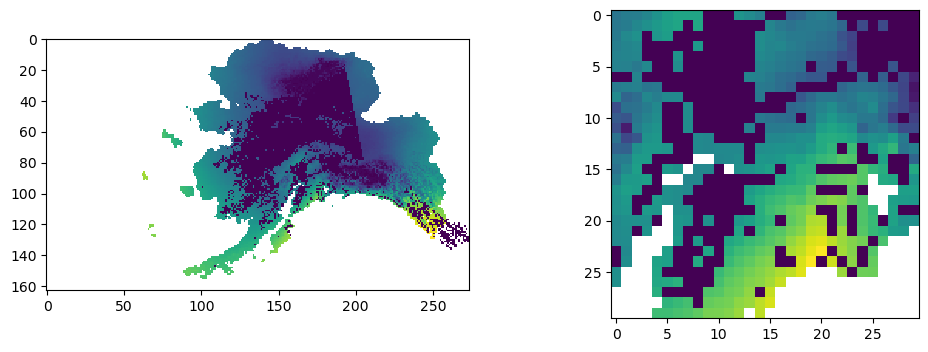

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

with rio.open(temp_ncar_clip_fp) as src:
    ncar_arr = src.read(1)
    print(src.profile)
    
with rio.open(ncar_forest_fp) as src:
    forest_arr = src.read(1).astype(float)
    print(src.profile)
    
forest_arr[forest_arr == 0] = np.nan
ax[0].imshow(ncar_arr, interpolation="none")
ax[0].imshow(forest_arr, interpolation="none")

ax[1].imshow(ncar_arr[80:110, 155:185], interpolation="none")
ax[1].imshow(forest_arr[80:110, 155:185], interpolation="none")
    
plt.show()

The left figure shows an overall view that the forest mask appears to correspond well with the shape of Alaska in the NCAR dataset. The right image shows a zoomed in view of Cook Inlet + Prince William Sound, showing complete overlap of pixel boundaries between layers.

Notice that the file metadata are essentially same too, only differing in their nodata value (nan vs 0.0).

Also view the general agreement of the new forest mask with the original forest mask:

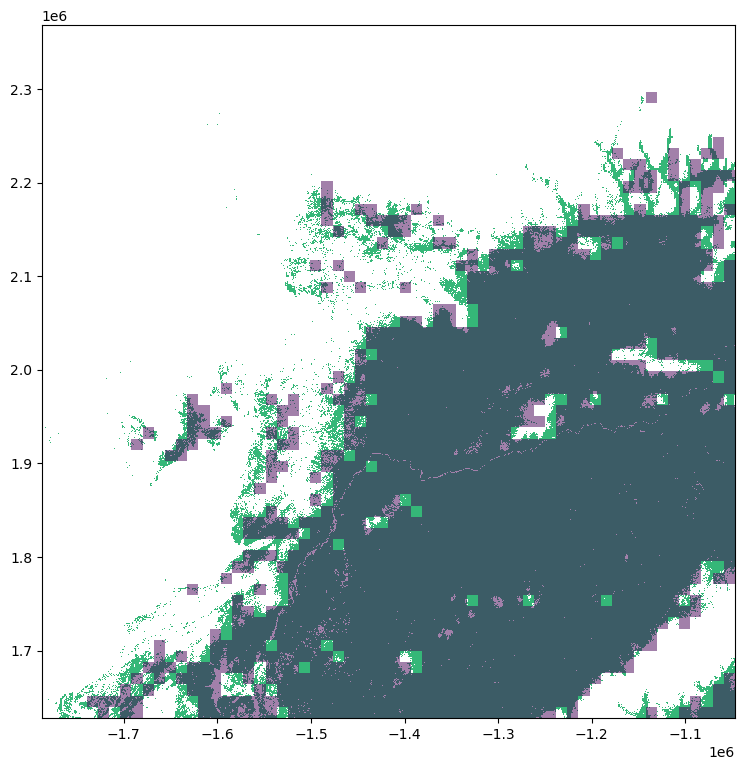

In [16]:
from rasterio.windows import Window


fig, ax = plt.subplots(1, figsize=(12, 9))

window = Window(5e3, 1e3, 3e3, 3e3)
with rio.open(forest_fp) as src:
    forest_arr = src.read(1, window=window).astype(float)
    forest_transform = src.transform

forest_arr[forest_arr == 0] = np.nan
show(forest_arr, interpolation="none", ax=ax, vmin=0, vmax=1.5, transform=forest_transform)

ncar_window=Window(104, 21, 62, 62)
with rio.open(ncar_forest_fp) as src:
    ncar_forest_arr = src.read(1, window=ncar_window).astype(float)
    ncar_forest_transform = src.transform

ncar_forest_arr[ncar_forest_arr == 0] = np.nan
show(ncar_forest_arr, interpolation="none", ax=ax, alpha=0.5, transform=ncar_forest_transform)
    
plt.show()

This image shows the original forest mask in green and the new NCAR forest mask in translucent purple for a window over western AK. This results in a dark green color where the two rasters match - looks pretty good.